In [185]:
import pandas as pd
import numpy as np
import nltk
from collections import defaultdict

### Import Scripts

In [186]:
episode_scripts_df = pd.read_csv("../05_Data/02_Clean/scripts_by_episodes.csv",index_col=0)
len(episode_scripts_df) #Number of Scripts should be 456

456

In [187]:
episode_scripts_df.head(3)

,season_ep,script
0,s01e01,Narrator In the criminal justice system the pe...
1,s01e02,Narrator In the criminal justice system the pe...
2,s01e03,Narrator In the criminal justice system the pe...


### Process Text for NLP

#### 1. Removing punctuation - Removed by the previous notebook (04_Clean_Scripts_by_Episode.ipynb) already
#### 2. Make Lowercase - Even though CountVectorizer and TFIDF already do this, why not do it manually here

In [188]:
episode_scripts_df["script"] = episode_scripts_df["script"].apply(lambda x: x.lower())
episode_scripts_df["script"][0][4500:4750]

'umonia she was fine when she got here she was dying when she got here god like pronouncements sound like normal medical procedure to me so max whats your problem meaning meaning your attitude 82 my partner and i go into this fleabag sro to pick up so'

#### 3. Remove Numbers

In [189]:
from string import digits
remove_digits = str.maketrans('', '', digits)
episode_scripts_df["script"] = episode_scripts_df["script"].apply(lambda x: x.translate(remove_digits))
episode_scripts_df["script"][0][4500:4750]

'onia she was fine when she got here she was dying when she got here god like pronouncements sound like normal medical procedure to me so max whats your problem meaning meaning your attitude  my partner and i go into this fleabag sro to pick up some j'

#### 4. Import Stopwords and  Remove Stopwords

In [190]:
law_order_stopwords = list(pd.read_csv("../05_Data/02_Clean/all_stopwords.csv",index_col=0)['0'])
law_order_stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [191]:
from nltk.tokenize import word_tokenize

def remove_stopwords(row):
    tokens = word_tokenize(row)
    tokens_clean = [word for word in tokens if not word in law_order_stopwords] 
    text_clean = " ".join(tokens_clean)
    return text_clean.strip()

In [192]:
episode_scripts_df["script"] = episode_scripts_df["script"].apply(remove_stopwords)

In [193]:
episode_scripts_df["script"][0][4500:4750]

'i depressant patient died worry doctor fine okay tox screen shows acetaminophen shows aspirin shows antihistamine theres sign meperidine huh uh ran standard gas chromatography know girl something called phenelzine meperidine phenelzine recreational d'

#### 5. Lemmatize Scripts

In [194]:
replace_dict = {"abused":"abuse", "adopted":"adoption", "bombing":"bomb", "fighting":"fight",
                "gangster":"gang","jew":"jewish","marriage":"married","medication":"medicine",
                "pregnancy":"pregnant","senate":"senator","shoot":"shooter","stabbed":"stab",
                "stabbing":"stab","suicidal":"suicide","russia":"russian","raped":"rape"}

In [195]:
from nltk.stem import WordNetLemmatizer

def lemma_my_text(row):
    tokens = word_tokenize(row)
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(y) for y in tokens]
    tokens_lemma = [x if x not in replace_dict else replace_dict[x] for x in tokens_lemma] #remap words in dict
    text_lemma = " ".join(tokens_lemma)
    return text_lemma.strip()

In [196]:
episode_scripts_df["script"] = episode_scripts_df["script"].apply(lemma_my_text)
episode_scripts_df["script"][0][4500:4750]

'cetaminophen show aspirin show antihistamine there sign meperidine huh uh ran standard gas chromatography know girl something called phenelzine meperidine phenelzine recreational drug another tox screen think wasting nickel nobody take meperidine phe'

### Vectorize

In [197]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

I included stopwords again here in case the stemming process truncated variants of each stopword, they will be caught again here

In [198]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),
                             stop_words=law_order_stopwords,
                             token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b", #words with >= 2 alpha chars
                             max_df=.50,
                             min_df=.015) 
X = vectorizer.fit_transform(episode_scripts_df["script"])
X.shape

(456, 7596)

In [199]:
n_grams = list(vectorizer.get_feature_names())
counts = list(sum(X.toarray()))
word_counts = list(zip(n_grams, counts))
pd.DataFrame(word_counts).sort_values(by=1,ascending=False).head(5)

,0,1
2140,dr,17.685133
511,baby,14.936293
5401,rape,11.930482
6152,sister,9.511598
1733,dad,9.035475


In [200]:
X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
X_df.head()

,abandon,abandoned,abdomen,abducted,abduction,abetting,abiding,ability,aboard,abortion,...,youthful,yup,yuppie,zealot,zealous,zero,zip,zone,zoo,zpass
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017892,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.043073,0.030232,0.0,0.0,0.0,0.000000,0.0,0.029771,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.030377,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.030492,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


### Fit NMF Model

In [201]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=16)
nmf_vecs = nmf.fit_transform(X_df) 

In [202]:
len(nmf_vecs)

456

### Explore Topics

#### How Many Episodes in Each Topic? 

In [307]:
topic, episode_count = np.unique(nmf_vecs.argmax(axis = 1), return_counts=True)   # Number of episodes in each category
topic_count_df = pd.DataFrame(list(zip(topic,episode_count)))
topic_count_df = topic_count_df.drop([0],axis=1)
topic_count_df = topic_count_df.rename({1:"num_eps"},axis=1)
topic_count_df

,num_eps
0,32
1,29
2,23
3,26
4,8
5,11
6,73
7,38
8,24
9,10


#### Print Out Topics

In [204]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "Topic #%d: " % index
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, "\n")
    print()

In [205]:
words = list(X_df.columns.values)
print_top_words(model=nmf,feature_names=words,n_top_words=30)

Topic #0: insurance loan bank account horse stock estate shore policy firm hired hire fraud fire property payment club market accident divorce owed coin dollar customer brooklyn wire arson profit financial loved 

Topic #1: dr patient surgery clinic hospital therapy medical cancer medicine therapist nurse abortion session shrink abuse psychiatrist procedure tape practice doc diary accident malpractice helmet physician treatment personality laser wasrt ex 

Topic #2: baby pregnant adoption crib birth abortion fetus chelsea hotel miscarriage born medical cry formula sperm healthy clinic autopsy test certificate poison paternity nurse milk backpack newborn pillow heat breast infant 

Topic #3: rape sex sexual sister singer consent rapist semen dna drunk sample ranger square tape parole prostitute drink library boyfriend fraternity clothes consented intercourse raping video bed bus firm congressman suite 

Topic #4: bomb abortion reverend explosive explosion train arson clinic dynamite tra

#### Visualize Topics

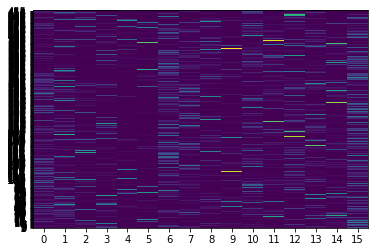

In [263]:
import matplotlib.pyplot as plt
eps_df = pd.DataFrame(nmf_vecs)

eps1_df = eps_df
plt.pcolor(eps1_df)
plt.yticks(np.arange(0.5, len(eps1_df.index), 1), eps1_df.index)
plt.xticks(np.arange(0.5, len(eps1_df.columns), 1), eps1_df.columns)
plt.show()

### Create Words in Topics DataFrame

In [287]:
def get_nmf_topics(model, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict[i] = words;
    
    return pd.DataFrame(word_dict).transpose();

In [288]:
topics_df = get_nmf_topics(model=nmf,num_topics=16)
topics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,insurance,loan,bank,account,horse,stock,estate,shore,policy,firm,hired,hire,fraud,fire,property,payment,club,market,accident,divorce
1,dr,patient,surgery,clinic,hospital,therapy,medical,cancer,medicine,therapist,nurse,abortion,session,shrink,abuse,psychiatrist,procedure,tape,practice,doc
2,baby,pregnant,adoption,crib,birth,abortion,fetus,chelsea,hotel,miscarriage,born,medical,cry,formula,sperm,healthy,clinic,autopsy,test,certificate
3,rape,sex,sexual,sister,singer,consent,rapist,semen,dna,drunk,sample,ranger,square,tape,parole,prostitute,drink,library,boyfriend,fraternity
4,bomb,abortion,reverend,explosive,explosion,train,arson,clinic,dynamite,trailer,martyr,blasting,terrorist,synagogue,bag,bomber,buzz,gas,cap,conspiracy
5,russian,kgb,brighton,bank,skate,speaking,gramercy,enterprise,flight,currency,foreign,truck,laundering,divorce,mob,plane,dream,brooklyn,country,american
6,affair,hotel,senator,governor,boat,letter,dna,relationship,alibi,mail,dinner,sex,blackmail,ex,reporter,tape,investigation,privilege,security,computer
7,knife,stab,mental,homeless,voice,wound,psychotic,attacked,behavior,psychiatric,insanity,confession,medicine,psychiatrist,madison,dress,violence,shelter,responsible,dad
8,soldier,war,iraq,army,military,american,colonel,terrorist,government,muslim,country,prisoner,captain,federal,mosque,political,navy,vest,video,united
9,jewish,reverend,hate,anti,speech,synagogue,de,wasrt,nazi,embassy,stealing,race,racist,violence,congregation,hatred,store,ghetto,harlem,sugar


### Create Topics in Episode DataFrame

Find Top Topic per Episode

In [209]:
max_topic = nmf_vecs.argmax(axis = 1)
topic_df = pd.DataFrame(max_topic)
topic_df = topic_df.rename({0:"topic"},axis=1)
topic_df.head()

,topic
0,1
1,15
2,11
3,6
4,15


Find Top Topic Score Per Episode

In [210]:
max_topic_score = nmf_vecs.max(axis = 1)
topic_score_df = pd.DataFrame(max_topic_score)
topic_score_df = topic_score_df.rename({0:"score"},axis=1)
topic_score_df.head()

,score
0,0.380267
1,0.139380
2,0.328722
3,0.107163
4,0.157249


Big Episode Topic Matrix

In [215]:
episode_topics_df = pd.DataFrame(nmf_vecs)
episode_topics_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.380267,0.000000,0.003791,0.000000,0.001068,0.000000,0.000000,0.012291,0.000000,0.000000,0.000000,0.019285,0.038327,0.000000,0.008754
1,0.000000,0.005877,0.024975,0.124810,0.008524,0.000000,0.000000,0.041899,0.000000,0.009996,0.000000,0.011568,0.000000,0.015861,0.001081,0.139380
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328722,0.000000,0.227104,0.011089,0.007953
3,0.022007,0.001738,0.000000,0.069170,0.000000,0.000844,0.107163,0.038305,0.000000,0.000000,0.032959,0.000000,0.026432,0.058988,0.025017,0.000000
4,0.018024,0.000000,0.013192,0.000000,0.000000,0.000000,0.048168,0.015766,0.000000,0.000000,0.000000,0.000000,0.014938,0.005044,0.022405,0.157249


Merge Episode DataFrames Together

In [224]:
eps_topic_comb_df = episode_scripts_df.merge(topic_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.merge(topic_score_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.merge(episode_topics_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.drop(["script"],axis=1)
eps_topic_comb_df.head()

,season_ep,topic,score,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,s01e01,1,0.380267,0.000000,0.380267,0.000000,0.003791,0.000000,0.001068,0.000000,0.000000,0.012291,0.000000,0.000000,0.000000,0.019285,0.038327,0.000000,0.008754
1,s01e02,15,0.139380,0.000000,0.005877,0.024975,0.124810,0.008524,0.000000,0.000000,0.041899,0.000000,0.009996,0.000000,0.011568,0.000000,0.015861,0.001081,0.139380
2,s01e03,11,0.328722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328722,0.000000,0.227104,0.011089,0.007953
3,s01e04,6,0.107163,0.022007,0.001738,0.000000,0.069170,0.000000,0.000844,0.107163,0.038305,0.000000,0.000000,0.032959,0.000000,0.026432,0.058988,0.025017,0.000000
4,s01e05,15,0.157249,0.018024,0.000000,0.013192,0.000000,0.000000,0.000000,0.048168,0.015766,0.000000,0.000000,0.000000,0.000000,0.014938,0.005044,0.022405,0.157249


### Name Topics

In [237]:
top_eps_per_topic = eps_topic_comb_df.sort_values(['topic','score'],ascending=False)[["season_ep","topic","score"]].groupby('topic').head(5)

In [299]:
top_eps_per_topic[top_eps_per_topic["topic"]==15]   #cycle through each time and look at scripts

,season_ep,topic,score
316,s14e16,15,0.281983
183,s09e03,15,0.278741
12,s01e13,15,0.273866
50,s03e07,15,0.266761
193,s09e13,15,0.244832


In [293]:
topic_dict = {0:"Finance/Organized Crime",1:"Medical Malpractice",2:"Infant/Baby Welfare",3:"Sexual Assault",
             4: "Bombing/Terrorism", 5:"Russian Mob", 6:"Political Corruption", 7:"Murder Defense", 8:"Military",
              9:"Judiasm",10:"Child Welfare",11:"Suicide",12:"School/University",13:"Infectious Diseases",
             14:"Religion", 15:"Drugs/Gangs/Robbery" }

In [294]:
topic_names_df = eps_topic_comb_df.rename(topic_dict,axis=1)
topic_names_df["topic"] = topic_names_df["topic"].map(topic_dict)

### Merge Topic Names with Episode Table & Export

In [295]:
topic_names_df.head()

,season_ep,topic,score,Finance/Organized Crime,Medical Malpractice,Infant/Baby Welfare,Sexual Assault,Bombing/Terrorism,Russian Mob,Political Corruption,Murder Defense,Military,Judiasm,Child Welfare,Suicide,School/University,Infectious Diseases,Religion,Drugs/Gangs/Robbery
0,s01e01,Medical Malpractice,0.380267,0.000000,0.380267,0.000000,0.003791,0.000000,0.001068,0.000000,0.000000,0.012291,0.000000,0.000000,0.000000,0.019285,0.038327,0.000000,0.008754
1,s01e02,Drugs/Gangs/Robbery,0.139380,0.000000,0.005877,0.024975,0.124810,0.008524,0.000000,0.000000,0.041899,0.000000,0.009996,0.000000,0.011568,0.000000,0.015861,0.001081,0.139380
2,s01e03,Suicide,0.328722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328722,0.000000,0.227104,0.011089,0.007953
3,s01e04,Political Corruption,0.107163,0.022007,0.001738,0.000000,0.069170,0.000000,0.000844,0.107163,0.038305,0.000000,0.000000,0.032959,0.000000,0.026432,0.058988,0.025017,0.000000
4,s01e05,Drugs/Gangs/Robbery,0.157249,0.018024,0.000000,0.013192,0.000000,0.000000,0.000000,0.048168,0.015766,0.000000,0.000000,0.000000,0.000000,0.014938,0.005044,0.022405,0.157249


In [296]:
topic_names_df.to_csv("../05_Data/04_Model_Output/full_episodes_by_topic.csv")

### Merge Topic Names with Word Table & Export

In [309]:
topic_words_df = topic_count_df.merge(topics_df,how='outer', left_index=True, right_index=True)
topic_words_df = topic_words_df.rename(topic_dict,axis=0)
topic_words_df.head(10)

,num_eps,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
Finance/Organized Crime,32,insurance,loan,bank,account,horse,stock,estate,shore,policy,...,hired,hire,fraud,fire,property,payment,club,market,accident,divorce
Medical Malpractice,29,dr,patient,surgery,clinic,hospital,therapy,medical,cancer,medicine,...,nurse,abortion,session,shrink,abuse,psychiatrist,procedure,tape,practice,doc
Infant/Baby Welfare,23,baby,pregnant,adoption,crib,birth,abortion,fetus,chelsea,hotel,...,born,medical,cry,formula,sperm,healthy,clinic,autopsy,test,certificate
Sexual Assault,26,rape,sex,sexual,sister,singer,consent,rapist,semen,dna,...,sample,ranger,square,tape,parole,prostitute,drink,library,boyfriend,fraternity
Bombing/Terrorism,8,bomb,abortion,reverend,explosive,explosion,train,arson,clinic,dynamite,...,martyr,blasting,terrorist,synagogue,bag,bomber,buzz,gas,cap,conspiracy
Russian Mob,11,russian,kgb,brighton,bank,skate,speaking,gramercy,enterprise,flight,...,foreign,truck,laundering,divorce,mob,plane,dream,brooklyn,country,american
Political Corruption,73,affair,hotel,senator,governor,boat,letter,dna,relationship,alibi,...,dinner,sex,blackmail,ex,reporter,tape,investigation,privilege,security,computer
Murder Defense,38,knife,stab,mental,homeless,voice,wound,psychotic,attacked,behavior,...,insanity,confession,medicine,psychiatrist,madison,dress,violence,shelter,responsible,dad
Military,24,soldier,war,iraq,army,military,american,colonel,terrorist,government,...,country,prisoner,captain,federal,mosque,political,navy,vest,video,united
Judiasm,10,jewish,reverend,hate,anti,speech,synagogue,de,wasrt,nazi,...,stealing,race,racist,violence,congregation,hatred,store,ghetto,harlem,sugar


In [310]:
topic_words_df.to_csv("../05_Data/04_Model_Output/full_episodes_topic_words.csv")

### Pickle The Model

In [301]:
import pickle

with open('full_episode_model.pkl', 'wb') as picklefile:
    pickle.dump(nmf_vecs, picklefile)